<a href="https://colab.research.google.com/github/Nassilya/Jaguar-Re-Identification/blob/main/IABD1G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nassilyabelguedj","key":"7796601a6d6a869ab2fbdbc03605b948"}'}

In [3]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
!kaggle competitions list | head


ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3    2026-04-15 23:59:00  Featured         2,207,152 Usd       1735           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection         2026-02-13 23:59:00  Research           200,000 Usd       1034           False  
https://www.kaggle.com/competitions/med-gemma-impact-challenge                   2026-02-24 23:59:00  Featured           100,000 Usd         83           False  
https://www.kaggle.com/competitions/stanford-rna-3d-folding-2                    2026-03-25 23:59:00  Featured            75,000 Usd        611           False  
https://www.kaggle.com/compe

In [5]:
!kaggle competitions download -c jaguar-re-id


100% 16.0G/16.0G [08:57<00:00, 32.7MB/s]
100% 16.0G/16.0G [08:57<00:00, 32.0MB/s]


In [6]:
!unzip jaguar-re-id.zip


Archive:  jaguar-re-id.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test/test/test_0001.png  
  inflating: test/test/test_0002.png  
  inflating: test/test/test_0003.png  
  inflating: test/test/test_0004.png  
  inflating: test/test/test_0005.png  
  inflating: test/test/test_0006.png  
  inflating: test/test/test_0007.png  
  inflating: test/test/test_0008.png  
  inflating: test/test/test_0009.png  
  inflating: test/test/test_0010.png  
  inflating: test/test/test_0011.png  
  inflating: test/test/test_0012.png  
  inflating: test/test/test_0013.png  
  inflating: test/test/test_0014.png  
  inflating: test/test/test_0015.png  
  inflating: test/test/test_0016.png  
  inflating: test/test/test_0017.png  
  inflating: test/test/test_0018.png  
  inflating: test/test/test_0019.png  
  inflating: test/test/test_0020.png  
  inflating: test/test/test_0021.png  
  inflating: test/test/test_0022.png  
  inflating: test/test/test_0023.png  


In [7]:
import os, zipfile, json, random
from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TF: 2.19.0
GPU: []


In [8]:
from pathlib import Path

data_dir = Path("/content/jaguar_data")
print(data_dir)


/content/jaguar_data


In [10]:
!ls -R /content

/content:
jaguar-re-id.zip  sample_submission.csv  test.csv  train.csv
sample_data	  test			 train

/content/sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md

/content/test:
test

/content/test/test:
test_0001.png  test_0076.png  test_0151.png  test_0226.png  test_0301.png
test_0002.png  test_0077.png  test_0152.png  test_0227.png  test_0302.png
test_0003.png  test_0078.png  test_0153.png  test_0228.png  test_0303.png
test_0004.png  test_0079.png  test_0154.png  test_0229.png  test_0304.png
test_0005.png  test_0080.png  test_0155.png  test_0230.png  test_0305.png
test_0006.png  test_0081.png  test_0156.png  test_0231.png  test_0306.png
test_0007.png  test_0082.png  test_0157.png  test_0232.png  test_0307.png
test_0008.png  test_0083.png  test_0158.png  test_0233.png  test_0308.png
test_0009.png  test_0084.png  test_0159.png  test_0234.png  test_0309.png
test_0010.png  test_0085.png  test_0160.pn

In [11]:
import pandas as pd
from pathlib import Path

#CSV sont directement dans /content/
train_df = pd.read_csv("/content/train.csv")
test_df  = pd.read_csv("/content/test.csv")
sub_df   = pd.read_csv("/content/sample_submission.csv")

#images sont dans des sous-dossiers
train_dir = Path("/content/train/train")
test_dir  = Path("/content/test/test")

# Vérification
print(f"Images d'entraînement trouvées : {len(list(train_dir.glob('*.png')))}")
print(f"Images de test trouvées : {len(list(test_dir.glob('*.png')))}")

#TEST
print(train_df.head())

Images d'entraînement trouvées : 1895
Images de test trouvées : 371
         filename ground_truth
0  train_0001.png        Abril
1  train_0002.png        Abril
2  train_0003.png        Abril
3  train_0004.png       Akaloi
4  train_0005.png       Akaloi


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["ground_truth"])
num_classes = train_df["label"].nunique()
print("Classes:", num_classes)

train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"]
)

print("Train split:", len(train_split), "Val split:", len(val_split))


Classes: 31
Train split: 1516 Val split: 379


In [13]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# safe ugmentations ---> a changer plus tard
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  # PNG
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    return img

# ResNet50 preprocessing
preprocess = keras.applications.resnet50.preprocess_input

def make_ds(df, directory, training=True):
    paths = df["filename"].apply(lambda x: str(directory / x)).values
    labels = df["label"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if training:
        ds = ds.shuffle(buffer_size=len(df), seed=42, reshuffle_each_iteration=True)

    def _map(path, label):
        img = load_image(path)
        if training:
            img = augment(img)
        img = preprocess(img)
        return img, tf.one_hot(label, depth=num_classes)

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_split, train_dir, training=True)
val_ds   = make_ds(val_split, train_dir, training=False)


In [14]:
EMB_DIM = 512
DROPOUT = 0.2
LR = 3e-4
EPOCHS = 15

base = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = False  # phase1 -> freeze

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT)(x)
embedding = layers.Dense(EMB_DIM, activation=None, name="embedding")(x)
embedding = layers.BatchNormalization()(embedding)
outputs = layers.Dense(num_classes, activation="softmax", name="softmax")(embedding)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,654,751 (94.05 MB)

 Trainable params: 1,066,015 (4.07 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [15]:
log_dir = "/content/logs/jaguar_resnet50"
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

ckpt_path = "/content/resnet50_cls_best.keras"
ckpt_cb = keras.callbacks.ModelCheckpoint(
    ckpt_path, monitor="val_accuracy", save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tensorboard_cb, early_cb, ckpt_cb]
)


Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 533s 11s/step - accuracy: 0.2977 - loss: 2.9377 - val_accuracy: 0.6570 - val_loss: 1.3103
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 516s 11s/step - accuracy: 0.7874 - loss: 0.8603 - val_accuracy: 0.7995 - val_loss: 0.7441
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 466s 10s/step - accuracy: 0.8724 - loss: 0.5368 - val_accuracy: 0.8575 - val_loss: 0.5793
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 471s 10s/step - accuracy: 0.9104 - loss: 0.3925 - val_accuracy: 0.8813 - val_loss: 0.4790
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 504s 10s/step - accuracy: 0.9399 - loss: 0.2718 - val_accuracy: 0.9208 - val_loss: 0.3601
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 547s 11s/step - accuracy: 0.9501 - loss: 0.2419 - val_accuracy: 0.9156 - val_loss: 0.3531
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 470s 10s/step - accuracy: 0.9697 - loss: 0.1799 - val_accuracy: 0.9208 - val_loss: 0.3613
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 511s 11s/step - accuracy: 0.9724 - loss: 0.1498 - val_accuracy: 0.

In [16]:
model.save('jaguar_model_epoch8.h5')
from google.colab import files
files.download('jaguar_model_epoch8.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Format natif recommandé par Keras
model.save('jaguar_model_final.keras')

from google.colab import files
files.download('jaguar_model_final.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Défreeze les 30 derniers blocs seulement (soft fine-tuning )
base.trainable = True

for layer in base.layers[:-30]:
    layer.trainable = False

FT_LR = 1e-5
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FT_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tensorboard_cb, early_cb, ckpt_cb]
)


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 584s 12s/step - accuracy: 0.9254 - loss: 0.2949 - val_accuracy: 0.9156 - val_loss: 0.3567
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 625s 13s/step - accuracy: 0.9561 - loss: 0.1950 - val_accuracy: 0.9182 - val_loss: 0.3538
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 673s 13s/step - accuracy: 0.9539 - loss: 0.1878 - val_accuracy: 0.9208 - val_loss: 0.3505
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 561s 12s/step - accuracy: 0.9715 - loss: 0.1357 - val_accuracy: 0.9182 - val_loss: 0.3474
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 624s 13s/step - accuracy: 0.9759 - loss: 0.1101 - val_accuracy: 0.9288 - val_loss: 0.3446
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 616s 13s/step - accuracy: 0.9751 - loss: 0.0972 - val_accuracy: 0.9314 - val_loss: 0.3377
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 572s 12s/step - accuracy: 0.9852 - loss: 0.0768 - val_accuracy: 0.9340 - val_loss: 0.3368
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 571s 12s/step - accuracy: 0.9780 - loss: 0.0849 - val_accuracy: 0.

In [19]:
# Recharge BEST modèle de classification
best_model = keras.models.load_model(ckpt_path)

# Modèle qui sort l'embedding
embed_model = keras.Model(
    inputs=best_model.input,
    outputs=best_model.get_layer("embedding").output
)


In [20]:
# images test uniques
unique_test_imgs = sorted(set(test_df["query_image"]) | set(test_df["gallery_image"]))
print("Unique test images:", len(unique_test_imgs))  # 371

def make_test_ds(filenames):
    paths = [str(test_dir / f) for f in filenames]
    ds = tf.data.Dataset.from_tensor_slices(paths)

    def _map(path):
        img = load_image(path)
        img = preprocess(img)
        return img

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).batch(64).prefetch(AUTOTUNE)
    return ds

test_imgs_ds = make_test_ds(unique_test_imgs)

test_embeddings = embed_model.predict(test_imgs_ds, verbose=1)
# L2 normalize (important pour cosine)
test_embeddings = test_embeddings / (np.linalg.norm(test_embeddings, axis=1, keepdims=True) + 1e-12)

print("Embeddings shape:", test_embeddings.shape)


Unique test images: 371
6/6 ━━━━━━━━━━━━━━━━━━━━ 99s 15s/step
Embeddings shape: (371, 512)


In [21]:
# mapping filename -> index
img_to_idx = {img: i for i, img in enumerate(unique_test_imgs)}

# cosine similarity matrix = dot product car embeddings normalisés
sim_matrix = test_embeddings @ test_embeddings.T  # [-1,1] approx

# Remap vers [0,1] (format Kaggle)
sim01 = (sim_matrix + 1.0) / 2.0
sim01 = np.clip(sim01, 0.0, 1.0)

# Extraire chaque pair
sims = np.empty(len(test_df), dtype=np.float32)

for i, row in enumerate(test_df.itertuples(index=False)):
    qi = img_to_idx[row.query_image]
    gi = img_to_idx[row.gallery_image]
    sims[i] = sim01[qi, gi]

submission = pd.DataFrame({
    "row_id": test_df["row_id"].values,
    "similarity": sims
})

# Validation rapide
assert submission.shape == (137270, 2)
assert submission["row_id"].iloc[0] == 0 and submission["row_id"].iloc[-1] == 137269
assert submission["similarity"].between(0, 1).all()

out_path = "/content/my_submission.csv"
submission.to_csv(out_path, index=False)
print("Saved:", out_path, " | size:", os.path.getsize(out_path)/1024/1024, "MB")
submission.head()


Saved: /content/my_submission.csv  | size: 2.1631851196289062 MB


,row_id,similarity
0,0,0.806233
1,1,0.675529
2,2,0.654526
3,3,0.632479
4,4,0.664891


In [22]:
from google.colab import files
files.download("/content/my_submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

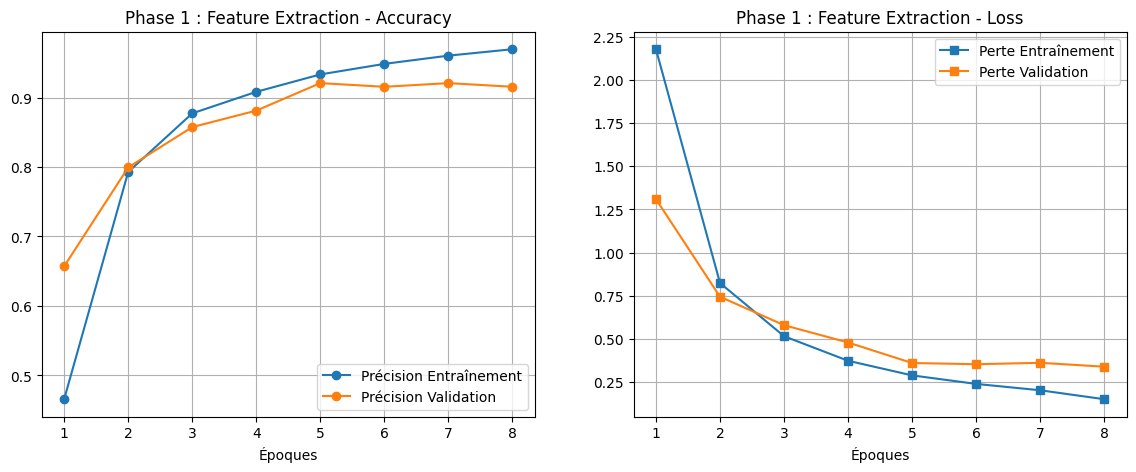

In [23]:
import matplotlib.pyplot as plt

def plot_training_results(history, title="Entraînement Initial"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Graphique de la Précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Précision Entraînement', marker='o')
    plt.plot(epochs_range, val_acc, label='Précision Validation', marker='o')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Époques')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Graphique de la Perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perte Entraînement', marker='s')
    plt.plot(epochs_range, val_loss, label='Perte Validation', marker='s')
    plt.title(f'{title} - Loss')
    plt.xlabel('Époques')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

# Affiche les premiers résultats
plot_training_results(history, title="Phase 1 : Feature Extraction")

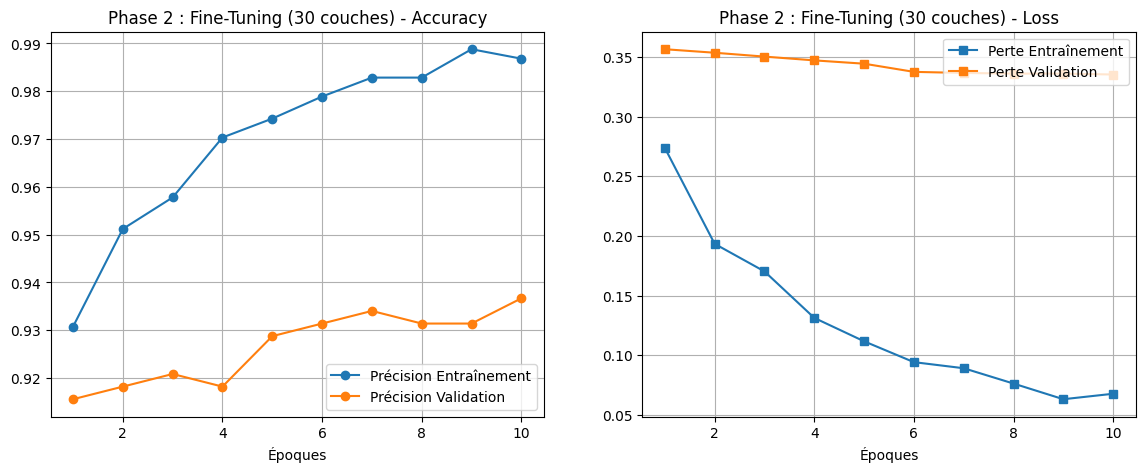

In [24]:
# Affiche les résultats du Fine-Tuning
plot_training_results(history_ft, title="Phase 2 : Fine-Tuning (30 couches)")